In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive

In [ ]:
%cd MyDrive

/gdrive/MyDrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import torch
import torchvision
import torchvision.transforms as t
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
# !pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pymatreader import read_mat
data = read_mat('Simulator/C_Difficult2_noise015.mat')

In [ ]:
spike_class = data['spike_class'][0][:]
spike_data = data['data']
spike_times = data['spike_times']

In [ ]:
idx_spike=spike_times
num_spike=len(spike_times)

In [ ]:
num_sample_forward=50
num_sample_backward=0
spike_curve=np.zeros((num_spike,num_sample_forward-num_sample_backward))
for i in range(num_spike):
    spike_curve[i]=spike_data[(idx_spike[i]+num_sample_backward):(idx_spike[i]+num_sample_forward)]

Text(0, 0.5, 'uV')

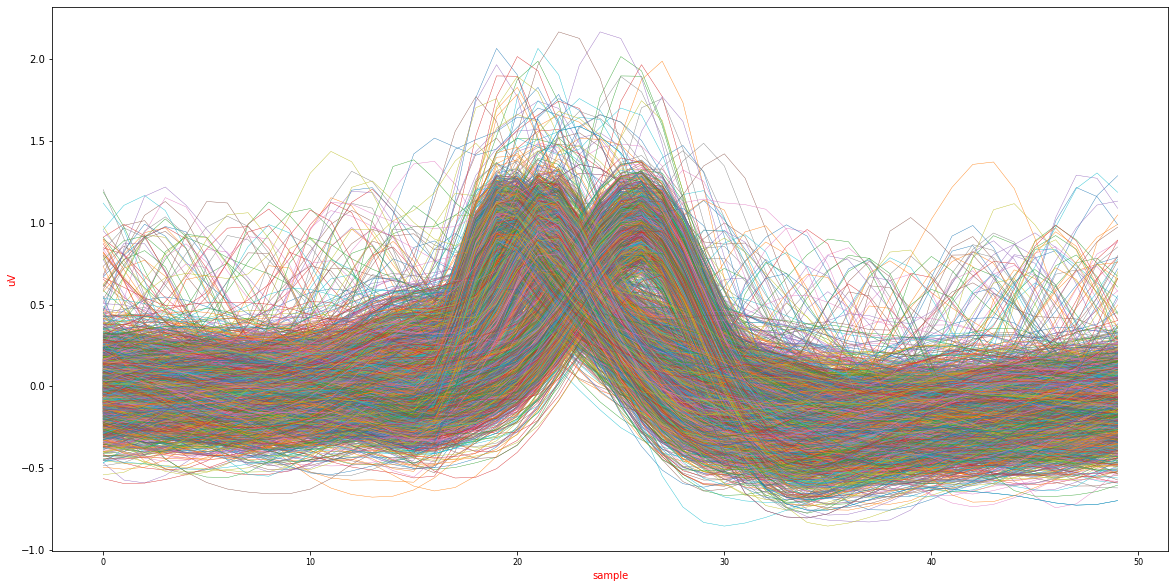

In [ ]:
plt.figure(figsize=(20,10))
for i in range(num_spike):
    plt.plot(spike_curve[i],linewidth=0.4)
plt.xticks(fontsize=8)
plt.xlabel('sample',color='red')
plt.ylabel('uV',color='red')

In [ ]:
wavelet = np.zeros((len(spike_curve), 3, 50, 50))

# Define the scales for the CWT
scales = np.arange(1, 51)

# Define the wavelet families
for i in range(len(spike_curve)):
    # Compute CWT coefficients for the first wavelet family
    cwtmatr = signal.cwt(spike_curve[i], signal.morlet, scales)
    wavelet[i, 0, :, :] = cwtmatr

    # Compute CWT coefficients for the second wavelet family
    cwtmatr = signal.cwt(spike_curve[i], signal.gaussian, scales)
    wavelet[i, 1, :, :] = cwtmatr

    # Compute CWT coefficients for the third wavelet family
    cwtmatr = signal.cwt(spike_curve[i], signal.ricker, scales)
    wavelet[i, 2, :, :] = cwtmatr



<ipython-input-21-8925bcb53d2b>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  wavelet[i, 0, :, :] = cwtmatr


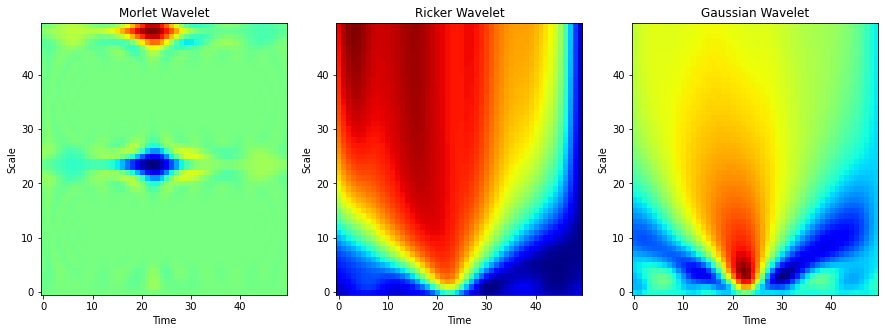

In [ ]:
spk = 29
# Get the CWT coefficients for the first spike curve for all three wavelets
morlet_coeffs =  wavelet[spk, 0, :, :]
ricker_coeffs =  wavelet[spk, 1, :, :]
gaussian_coeffs =  wavelet[spk, 2, :, :]

# Plot the scalograms for all three wavelets
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(morlet_coeffs, aspect='auto', cmap='jet', origin='lower')
axs[0].set_title('Morlet Wavelet')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Scale')

axs[1].imshow(ricker_coeffs, aspect='auto', cmap='jet', origin='lower')
axs[1].set_title('Ricker Wavelet')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Scale')

axs[2].imshow(gaussian_coeffs, aspect='auto', cmap='jet', origin='lower')
axs[2].set_title('Gaussian Wavelet')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Scale')

plt.show()

In [ ]:
class ThreeChannelNet(nn.Module):
    def __init__(self):
        super(ThreeChannelNet, self).__init__()

        # First convolutional branch
        self.conv1_ch1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.pool1_ch1 = nn.MaxPool2d(2,2)
        self.conv2_ch1 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.pool2_ch1 = nn.MaxPool2d(2,2)
        self.conv3_ch1 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.pool3_ch1 = nn.MaxPool2d(2,2)


        # Second convolutional branch
        self.conv1_ch2 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.pool1_ch2 = nn.MaxPool2d(2,2)
        self.conv2_ch2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.pool2_ch2 = nn.MaxPool2d(2,2)
        self.conv3_ch2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.pool3_ch2 = nn.MaxPool2d(2,2)

        # Third convolutional branch
        self.conv1_ch3 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.pool1_ch3 = nn.MaxPool2d(2,2)
        self.conv2_ch3 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.pool2_ch3 = nn.MaxPool2d(2,2)
        self.conv3_ch3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.pool3_ch3 = nn.MaxPool2d(2,2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3= nn.Linear(512, 128)
        self.fc4= nn.Linear(128, 3)


    def forward(self, x):
        # Separate the three channels
        x_ch1 = x[0,0, :, :]
        x_ch2 = x[0,1, :, :]
        x_ch3 = x[0,2, :, :]
        x_ch1 = x_ch1.unsqueeze(0).unsqueeze(0)
        x_ch2 = x_ch2.unsqueeze(0).unsqueeze(0)
        x_ch3 = x_ch3.unsqueeze(0).unsqueeze(0)
        # First convolutional branch
        x_ch1 = self.conv1_ch1(x_ch1)
        x_ch1 = nn.functional.relu(x_ch1)
        x_ch1 = self.pool1_ch1(x_ch1)
        x_ch1 = self.conv2_ch1(x_ch1)
        x_ch1 = nn.functional.relu(x_ch1)
        x_ch1 = self.pool2_ch1(x_ch1)
        x_ch1 = self.conv3_ch1(x_ch1)
        x_ch1 = nn.functional.relu(x_ch1)
        x_ch1 = self.pool3_ch1(x_ch1)

        # Second convolutional branch
        x_ch2 = self.conv1_ch2(x_ch2)
        x_ch2 = nn.functional.relu(x_ch2)
        x_ch2 = self.pool1_ch2(x_ch2)
        x_ch2 = self.conv2_ch2(x_ch2)
        x_ch2 = nn.functional.relu(x_ch2)
        x_ch2 = self.pool2_ch2(x_ch2)
        x_ch2 = self.conv3_ch2(x_ch2)
        x_ch2 = nn.functional.relu(x_ch2)
        x_ch2 = self.pool3_ch2(x_ch2)

        # Third convolutional branch
        x_ch3 = self.conv1_ch3(x_ch3)
        x_ch3 = nn.functional.relu(x_ch3)
        x_ch3 = self.pool1_ch3(x_ch3)
        x_ch3 = self.conv2_ch3(x_ch3)
        x_ch3 = nn.functional.relu(x_ch3)
        x_ch3 = self.pool2_ch3(x_ch3)
        x_ch3 = self.conv3_ch3(x_ch3)
        x_ch3 = nn.functional.relu(x_ch3)
        x_ch3 = self.pool3_ch3(x_ch3)
        # Concatenate the extracted features from the three branches
        x = torch.cat((x_ch1, x_ch2, x_ch3), dim=1)
        # Flatten the features and pass them through the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = nn.functional.relu(x)
        x = self.fc4(x)

        return x


In [ ]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ThreeChannelNet()
print("The model will be running on", device, "device\n")
model.to(device)    # Convert model parameters and buffers to CPU or Cuda
summary(model, (3, 50, 50))

The model will be running on cuda:0 device

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             160
         MaxPool2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 22, 22]           4,640
         MaxPool2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 9, 9]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7           [-1, 16, 48, 48]             160
         MaxPool2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,640
        MaxPool2d-10           [-1, 32, 11, 11]               0
           Conv2d-11             [-1, 64, 9, 9]          18,496
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Conv2d-13           [-1, 16, 48, 48]            

In [ ]:
# dd = torch.randn([1,3,50,50]).to(device)
# print(model(dd))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# Load your data and labels
label = spike_class-1
data = wavelet
mean = np.mean(data)
std = np.std(data)
data = (data - mean) / std


X_train, test_data, X_label, test_label = train_test_split(data, label, test_size=0.50,stratify=label,shuffle = True)
train_data, val_data, train_label, val_label = train_test_split(X_train, X_label, test_size=0.05,stratify=X_label,shuffle = True)

# Convert the data and labels to PyTorch tensors
train_inputs = torch.from_numpy(train_data).float()
val_inputs = torch.from_numpy(val_data).float()
test_inputs = torch.from_numpy(test_data).float()

train_labels = torch.from_numpy(train_label).float()
val_labels = torch.from_numpy(val_label).float()
test_labels = torch.from_numpy(test_label).float()



In [ ]:
print(train_inputs.shape)
print(val_inputs.shape)
print(test_inputs.shape)
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

torch.Size([1634, 3, 50, 50])
torch.Size([86, 3, 50, 50])
torch.Size([1720, 3, 50, 50])
torch.Size([1634])
torch.Size([86])
torch.Size([1720])


In [ ]:
num_epochs = 50

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.ASGD(model.parameters(), lr=0.01)
inputs = torch.tensor([])
# Train the network
for epoch in range(num_epochs):
  training_loss = 0
  loss_back = 0
  for i in range(0, train_inputs.size(0)):
    # Get the input and labels for the current batch
    inputs = train_inputs[i:i+1].to(device)
    labels = train_labels[i:i+1].to(device)
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels.long())
    training_loss += loss
    loss_back += loss
    # Zero the gradients
    if i % 2 == 0:
        optimizer.zero_grad()
        # Backward pass and optimization
        loss_back.backward()
        optimizer.step()
        loss_back = 0
  training_loss = training_loss/train_inputs.size(0)
  print('******************************************************************')
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss))
  with torch.no_grad():
          correct = 0
          val_loss = 0
          for j in range(0,val_inputs.size(0)):
            # Get the input and labels for the current batch
            inputs = val_inputs[j:j+1].to(device)
            labels = val_labels[j:j+1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += loss
          val_loss = val_loss/val_inputs.size(0)
          print('Validation Loss: {:.4f}'.format(val_loss))
          print('Validation Accuracy: {:.2f}% ({}/{})'.format(100*correct/val_inputs.size(0), correct, val_inputs.size(0)))

# Test the network on the test set
with torch.no_grad():
  test_loss = 0
  correct = 0
  total = 0
  for i in range(0, test_inputs.size(0)):
        # Get the input and labels for the current batch
        inputs = test_inputs[i:i+1].to(device)
        labels = test_labels[i:i+1].to(device)
        outputs = model(inputs)
        # Get the predictions
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels.long())
        test_loss += loss

print('Test Loss: {:.4f}'.format(test_loss/test_inputs.size(0)))
print('Test Accuracy: {:.2f}% ({}/{})'.format(100*correct/test_inputs.size(0) , correct, test_inputs.size(0)))





******************************************************************
Epoch [1/50], Loss: 0.9596
Validation Loss: 0.4684
Validation Accuracy: 67.44% (58/86)
******************************************************************
Epoch [2/50], Loss: 0.3225
Validation Loss: 0.0237
Validation Accuracy: 98.84% (85/86)
******************************************************************
Epoch [3/50], Loss: 0.0837
Validation Loss: 0.0101
Validation Accuracy: 98.84% (85/86)
******************************************************************
Epoch [4/50], Loss: 0.0484
Validation Loss: 0.0015
Validation Accuracy: 100.00% (86/86)
******************************************************************
Epoch [5/50], Loss: 0.0388
Validation Loss: 0.0013
Validation Accuracy: 100.00% (86/86)
******************************************************************
Epoch [6/50], Loss: 0.0256
Validation Loss: 0.0028
Validation Accuracy: 100.00% (86/86)
******************************************************************
Epoch 